## Overview

For our project we decided to build a classifier to tell whenever a song (based on its audio features) is gonna be popular or not. For that purpose, have a main dataset of Spotify tracks from 1921 to 2020 from which we will use a subset of the last 10 years for this project; additionally, we have datasets for top tracks of the last 10 years, which we can use for aiding in the training and prediction of our model. The datasets we are gonna be using are:

- Tracks - https://www.kaggle.com/yamaerenay/spotify-dataset-19212020-160k-tracks
- Top 2010 to 2019 - https://www.kaggle.com/leonardopena/top-spotify-songs-from-20102019-by-year
- Top 2017 - https://www.kaggle.com/nadintamer/top-tracks-of-2017
- Top 2018 - https://www.kaggle.com/nadintamer/top-spotify-tracks-of-2018
- Top 2019 - https://www.kaggle.com/leonardopena/top50spotify2019

Each of the datases, while being from Spotify, is bit different from one another (column names, scale, etc). Therefore, the preprocessing phase of our project focuses on making these datasets compatible with one another.

### Preprocessing

The general process we will follow for our **secondary** datasets (top charts) is:

1. Normalize the column names of each dataset so they have the same columns.

2. Keep only common columns.

3. Mark each dataset by year.

4. Merge them into a single dataframe.

We can then use our "top charts" dataframe for creating new features in our main dataset,
indicating if a given track ever made it to the top charts for a given year.

### Exploration

Start by exploring our **main** dataset and our **top charts** dataset (result from preprocessing step).

## Reading datasets

In [1]:
import pandas as pd
import numpy as np
import os

In [2]:
def read_dataset(name):
    url = os.path.join(os.getcwd(), '..', 'resources', name)
    return pd.read_csv(url)


In [3]:
datasets = [
    read_dataset('tracks-1921-2020.csv'),
    read_dataset('top-tracks-2010-to-2019.csv'),
    read_dataset('top-tracks-2017.csv'),
    read_dataset('top-tracks-2018.csv'),
    read_dataset('top-tracks-2019.csv'),
]

# indices constants for easier access later one
TRACKS_1921_2020 = 0
TOP_2010_2019_IDX = 1
TOP_2017_IDX = 2
TOP_2018_IDX = 3
TOP_2019_IDX = 4

## Preprocessing

### Normalizing columns

Some of the datasets have different column names to represent the same kind of metadata (name vs. title) or audio features (loudness vs. decibels). To address that, we are gonna normalize the columns so all the datasets have the same column names.

#### Column normalizer class

Let's get started by writing a column normalizer class that we can use later. The class focuses on mapping column names to a "desired" column set given as parameter, the class decides what column name corresponds to what input based on similarity tests.

In [4]:
from collections import namedtuple
from fuzzywuzzy import fuzz


Change = namedtuple('Change', ['before', 'after'])


class ColumnNormalizer:
    
    def __init__(self):
        pass
        
    def _compute_best_match(self, columns, oldname):
    
        best_match = None
        best_match_ratio = 0
        
        for colname in columns:
            ratio = fuzz.ratio(colname.lower(), oldname.lower())
            if ratio >= 60 and ratio > best_match_ratio:
                best_match = colname
                best_match_ratio = ratio
                
        return best_match
    
    def normalize(self, desired, desired_map, df):
        """
        Normalizes the column names of the given dataframe by looking at the `desired`
        set and the `desired_map` for supervised normalization. The `desired_map` 
        should contain a mapping from old names to desired names.
        """
        
        desired = desired or set()
        desired_map = desired_map or dict()
        
        guide = {name: name for name in desired}
        guide.update(desired_map)
        guide_keys = guide.keys()
        
        column_names = list(df.columns)
        changed = list()
        not_changed = list()
        
        for idx, colname in enumerate(column_names):
            
            best_key = self._compute_best_match(guide_keys, colname)

            if best_key is not None:
                column_names[idx] = guide[best_key]
                changed.append(Change(colname, guide[best_key]))
                
            else:
                not_changed.append(Change(colname, None))
                
        df.columns = column_names
        return df, changed, not_changed


/opt/conda/lib/python3.8/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


#### Finding desired columns

Since most if not all of the datasets come from Spotify, we can look at their [API reference](https://developer.spotify.com/documentation/web-api/reference/tracks/get-several-audio-features/) to figure out which columns to expect. Easily enough, these are the most important columns we should try to get:

In [5]:
desired_columns = [
    
    # metadata
    'id',
    'artist',
    'title',
    'duration_ms',
    'genre',
    'popularity',
    'year',

    # audio features
    'acousticness',
    'danceability',
    'energy',
    'explicit',
    'instrumentalness',
    'key',
    'liveness',
    'loudness',
    'mode',
    'speechiness',
    'tempo',
    'time_signature',
    'valence',
    
]

Since some of the datasets have badly naming columns, we have to provide a a desired map to the `ColumnNormalizer` for supervised column renaming. Said map is given by:

In [6]:
desired_columns_map = {
    
    'unamed': 'id',
    'bpm': 'tempo',
    'dnce': 'danceability',
    'db': 'loudness',
    'acous': 'acousticness',
    'spch': 'speechness',
    'pop': 'popularity',
    'Track.name': 'title',
    'beats.per.minute': 'tempo',
    'length': 'duration_ms',
    'dur': 'duration_ms',
    'name': 'title',
    'release_date': 'release_date',
    
}

#### Applying column normalization

Finally, we apply the `ColumnNormalizer` on each dataset to normalize the column names:

In [7]:
cnorm =  ColumnNormalizer()

changeset = set()
unchangeset = set()

for idx, dataset in enumerate(datasets):
    normalized, changed, not_changed = cnorm.normalize(desired_columns, desired_columns_map, dataset)
    changeset.update(changed)
    unchangeset.update(not_changed)
    datasets[idx] = normalized

To make sure no columns where left unchanged, we can simply check the `unchangeset` and make sure is empty:

In [8]:
assert len(unchangeset) == 0

### Marking by year

Since our `TOP_2010_2019_IDX` dataset is already marked by year, we only have to mark the remaining top charts datasets:

In [9]:
datasets[TOP_2017_IDX] = datasets[TOP_2017_IDX].assign(year=2017)
datasets[TOP_2018_IDX] = datasets[TOP_2018_IDX].assign(year=2018)
datasets[TOP_2019_IDX] = datasets[TOP_2019_IDX].assign(year=2019)

### Keeping common columns

Now that all the column names are normalized we can simply drop the columns that are not common in all our **secondary** datasets.

In [10]:
# grab only the secondary datasets with their index
secondary = list(enumerate(datasets))[1:]

all_columns = set()
for _, dataset in secondary:
    all_columns.update(dataset.columns)

common = set(all_columns)
for _, dataset in secondary:
    common.intersection_update(dataset.columns)

Then, we just have to update each **secondary** dataset and keep only the common column between them:

In [11]:
common_columns = sorted(list(common))

for idx, dataset in secondary:
    datasets[idx] = dataset[common_columns]

### Merging top charts

Now that all our top charts columns are normalized, they can be merged together. Note that we are only interested in `artist`, `title` and `year` (for determining if a song was in the top charts):

In [12]:
top_charts = pd.concat(datasets[1:])[['artist', 'title', 'year']]
top_charts

,artist,title,year
0,Train,"Hey, Soul Sister",2010
1,Eminem,Love The Way You Lie,2010
2,Kesha,TiK ToK,2010
3,Lady Gaga,Bad Romance,2010
4,Bruno Mars,Just the Way You Are,2010
...,...,...,...
45,Marshmello,One Thing Right,2019
46,Nicky Jam,Te Robaré,2019
47,Marshmello,Happier,2019
48,The Chainsmokers,Call You Mine,2019


### Top charts feature on main dataset

Based on the merged top charts, we are now going to add new binary feature to our main dataset that indicates if a song was in the top charts. In order to do so, we use our `top_charts` dataset as a lookup table, any row in the main dataset that is found in the top charts will marked with a `Y`, any other row will be marked with `N`. First let us prepare the `top_charts` so we can use it as a lookup table more efficiently:

In [13]:
import re

# removes any non-letter character from the given string
def normalize_string(s):
    return re.sub(r'\W+', '', s.lower())

# compares the given strings and returns similarity ratio
def string_ratio(a, b):
    return SequenceMatcher(None, a, b).ratio()


In [14]:
top_charts['artist'] = top_charts['artist'].map(normalize_string)
top_charts['title'] = top_charts['title'].map(normalize_string)
top_charts = top_charts.drop_duplicates()
top_charts

,artist,title,year
0,train,heysoulsister,2010
1,eminem,lovethewayyoulie,2010
2,kesha,tiktok,2010
3,ladygaga,badromance,2010
4,brunomars,justthewayyouare,2010
...,...,...,...
42,ladygaga,shallow,2019
43,khalid,talk,2019
44,rosalía,conaltura,2019
45,marshmello,onethingright,2019


#### Generating `topcharts` feature

In [ ]:
import re
from fuzzywuzzy import fuzz


def find_track(artist, title, lookup, artist_threshold=0.5, title_threshold=0.75):
    """
    Determines if the given track (artist, title) is in the given lookup table.
    Uses similarity comparison on both fields, so it may be slow for large datasets.
    """
    r = lookup.copy()
    r['artist'] = r['artist'].map(lambda x: fuzz.ratio(artist, x))
    r['title'] = r['title'].map(lambda x: fuzz.ratio(title, x))
    return not r[(r['artist'] >= artist_threshold * 100) & (r['title'] >= title_threshold * 100)].empty


# grab last 10 years from our main dataset
last_10_years = datasets[0][datasets[0]['year'] >= 2010]
last_10_years = last_10_years.assign(topcharts='N')
last_10_years = last_10_years.reset_index(drop=True)


total_rows = len(last_10_years.index)


for idx, row in enumerate(last_10_years.itertuples()):
    
    artist = normalize_string(row.artist)
    title = normalize_string(row.title)
    
    if find_track(artist, title, top_charts):
        last_10_years.at[idx, 'topcharts'] = 'Y'
        
    if idx % 1000 == 0:
        print(f"Completed {idx / total_rows * 100}%")
        

In [ ]:
last_10_years[last_10_years['topcharts'] == 'Y']

last_10_years.to_csv('tracks-2010-2019.csv')
last_10_years

## Exploration

1. Feature reduction (checking correlation, scatter plots, correlation plots).

2. Check the popularity stats on topcharts partitions (`Y` vs. `N`).

3. Based on the exploration decide the approach to define final class label that we are gonna use for prediction.

#### Checking correlation matrix
Note that we excluded attributes that have a string data type from the selection to see the correlation score for each combination of attributes

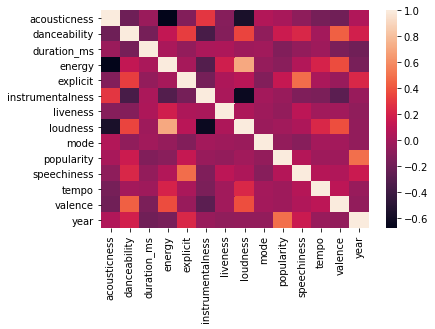

In [18]:
import seaborn as sb

columns = ['acousticness','danceability',
       'duration_ms', 'energy', 'explicit', 'instrumentalness',
       'liveness', 'loudness', 'mode', 'popularity',
       'release_date', 'speechiness', 'tempo', 'valence', 'year',
       'topcharts']

sb.heatmap(last_10_years[columns].corr())

#### Checking scatterplot